# ROC Analysis

### Imports

In [1]:
import pandas as pd
import scipy.stats
import re
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib as mpl #Some more style nonsense
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi']=300 # dots per inch

## Extracting calculated properties data

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131


In [3]:
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])
calculatedProperties

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,49,S,A,0.061363,3.265,1.663182,0.992308,23.461148,33.713100
1,49,S,C,0.067352,7.990,4.028676,0.992308,23.461148,33.713100
2,49,S,D,-0.103203,1.891,0.893899,0.992308,23.461148,33.713100
3,49,S,E,-0.086741,0.983,0.448129,0.992308,23.461148,33.713100
4,49,S,F,0.182080,4.837,2.509540,0.992308,23.461148,33.713100
...,...,...,...,...,...,...,...,...,...
8773,510,K,S,0.571362,1.871,1.221181,0.717073,14.891393,15.359364
8774,510,K,T,0.862076,1.330,1.096038,0.717073,14.891393,15.359364
8775,510,K,V,1.125190,-0.576,0.274595,0.717073,14.891393,15.359364
8776,510,K,W,0.686269,-0.158,0.264134,0.717073,14.891393,15.359364


## Extracting BayesDel data
Now we will take our BayesDel data which I've labelled as `BayesDel` below for convenience. Big thank you to Keyu for the data.

In [4]:
StatisticalScores = pd.read_csv("./FH_mutations_6.csv")

In [5]:
# need to match column names to that of calculatedProperties
StatisticalScores.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

StatisticalScores.head()

,pos(1-based),AAto,AAfrom,ref,alt,Residue,HGVSc_VEP,HGVSp_VEP,rs_dbSNP,BayesDel_noAF_score,BayesDel_addAF_score,BayesDel_addAF_rankscore,REVEL_score,REVEL_rankscore,clinvar_clnsig,clinvar_review
0,241497831,N,K,C,A;G,510,c.1530G>C;c.1530G>T,p.Lys510Asn,.;.,0.052162,0.201846,0.73872,0.694,0.88865,.,.;.
1,241497832,M,K,T,A,510,c.1529A>T,p.Lys510Met,.,0.226338,0.323103,0.84583,0.755,0.91594,.,.
2,241497832,R,K,T,C,510,c.1529A>G,p.Lys510Arg,rs2147911174,0.090205,0.228331,0.76389,0.526,0.79842,Uncertain_significance,"criteria_provided,_multiple_submitters,_no_con..."
3,241497832,T,K,T,G,510,c.1529A>C,p.Lys510Thr,.,0.257605,0.344870,0.86065,0.699,0.89099,.,.
4,241497833,E,K,T,C,510,c.1528A>G,p.Lys510Glu,.,0.199121,0.304155,0.83174,0.629,0.85650,Uncertain_significance,"criteria_provided,_single_submitter"


In [6]:
# there's only some tables I want to keep
StatisticalScores = StatisticalScores[["AAfrom","AAto","Residue","REVEL_score","BayesDel_noAF_score","BayesDel_addAF_score"]]

In [7]:
StatisticalScores.head()

,AAfrom,AAto,Residue,REVEL_score,BayesDel_noAF_score,BayesDel_addAF_score
0,K,N,510,0.694,0.052162,0.201846
1,K,M,510,0.755,0.226338,0.323103
2,K,R,510,0.526,0.090205,0.228331
3,K,T,510,0.699,0.257605,0.344870
4,K,E,510,0.629,0.199121,0.304155


In [8]:
len(StatisticalScores)

3048

In [9]:
excluded_residues = np.array([56, 59, 61, 65, 66, 71, 77, 80, 85, 87, 108, 109, 
                              115, 125, 131, 134, 224, 287, 292, 309, 457, 460, 
                              462, 466, 467, 483, 496, 498, 505, 510])
StatisticalScores_removed = StatisticalScores[StatisticalScores["Residue"].isin(excluded_residues)]
print(len(StatisticalScores_removed))
StatisticalScores = StatisticalScores[~StatisticalScores["Residue"].isin(excluded_residues)]

190


In [10]:
benign = StatisticalScores[
    (StatisticalScores['REVEL_score'] <= 0.6488) & 
    (StatisticalScores['BayesDel_noAF_score'] <= 0.1217) & 
    (StatisticalScores['BayesDel_addAF_score'] <= 0.2501)
]

In [11]:
deleterious = StatisticalScores[
    (StatisticalScores['REVEL_score'] >= 0.6488) & 
    (StatisticalScores['BayesDel_noAF_score'] >= 0.1217) & 
    (StatisticalScores['BayesDel_addAF_score'] >= 0.2501)
]

In [12]:
# converting tables to string to avoid potential errors
calculatedProperties = calculatedProperties.astype(str)
benign = benign.astype(str)
deleterious = deleterious.astype(str)

In [13]:
# merging datasets to get ready for binary classification
bs_calc = benign.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])
ds_calc = deleterious.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

In [14]:
len(bs_calc)

462

In [15]:
len(ds_calc)

1923

In [16]:
# add source column to benign and deleterious tables for classification
bs_calc["source"] = "neutral"
ds_calc["source"] = "deleterious"

In [17]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,REVEL_score,BayesDel_noAF_score,BayesDel_addAF_score,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,source_deleterious,source_neutral
0,L,V,507,0.542,-0.0576501,0.125399,1.88196,2.48,2.18098,0.213414634,15.11647605,6.032148733,0,1
1,K,N,504,0.301,-0.2726775,-0.02429705,1.27046,3.16,2.21523,0.712195122,19.79394051,9.103497551,0,1
2,K,M,504,0.547,-0.0999501,0.0959506,-0.0587314,0.13,0.0356343,0.712195122,19.79394051,9.103497551,0,1
3,K,R,504,0.35,-0.295394,-0.0401116,0.0746738,0.553,0.3138369,0.712195122,19.79394051,9.103497551,0,1
4,K,T,504,0.377,-0.200993,0.0256075,0.979451,3.762,2.3707255,0.712195122,19.79394051,9.103497551,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,R,P,51,0.891,0.497248,0.511702,3.97582,17.75,10.86291,0.14516129,17.42033636,32.27567249,1,0
1919,R,Q,51,0.928,0.503181,0.515832,2.40467,7.509,4.956835,0.14516129,17.42033636,32.27567249,1,0
1920,R,G,51,0.789,0.438676,0.470926,3.0131,9.092,6.05255,0.14516129,17.42033636,32.27567249,1,0
1921,R,W,51,0.799,0.446505,0.350002,2.569,2.542,2.5555,0.14516129,17.42033636,32.27567249,1,0


In [18]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
logreg_x = logreg_data[["Foldx_energy", "Rosetta_energy", "average_energy","Mindist_bindingsiteA","Mindist_hinge","RSA"]]

logreg_x = logreg_x.astype(float)
plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

true_values = plotting_frame["source_deleterious"].to_list()

## ROC Curve: FoldX energy

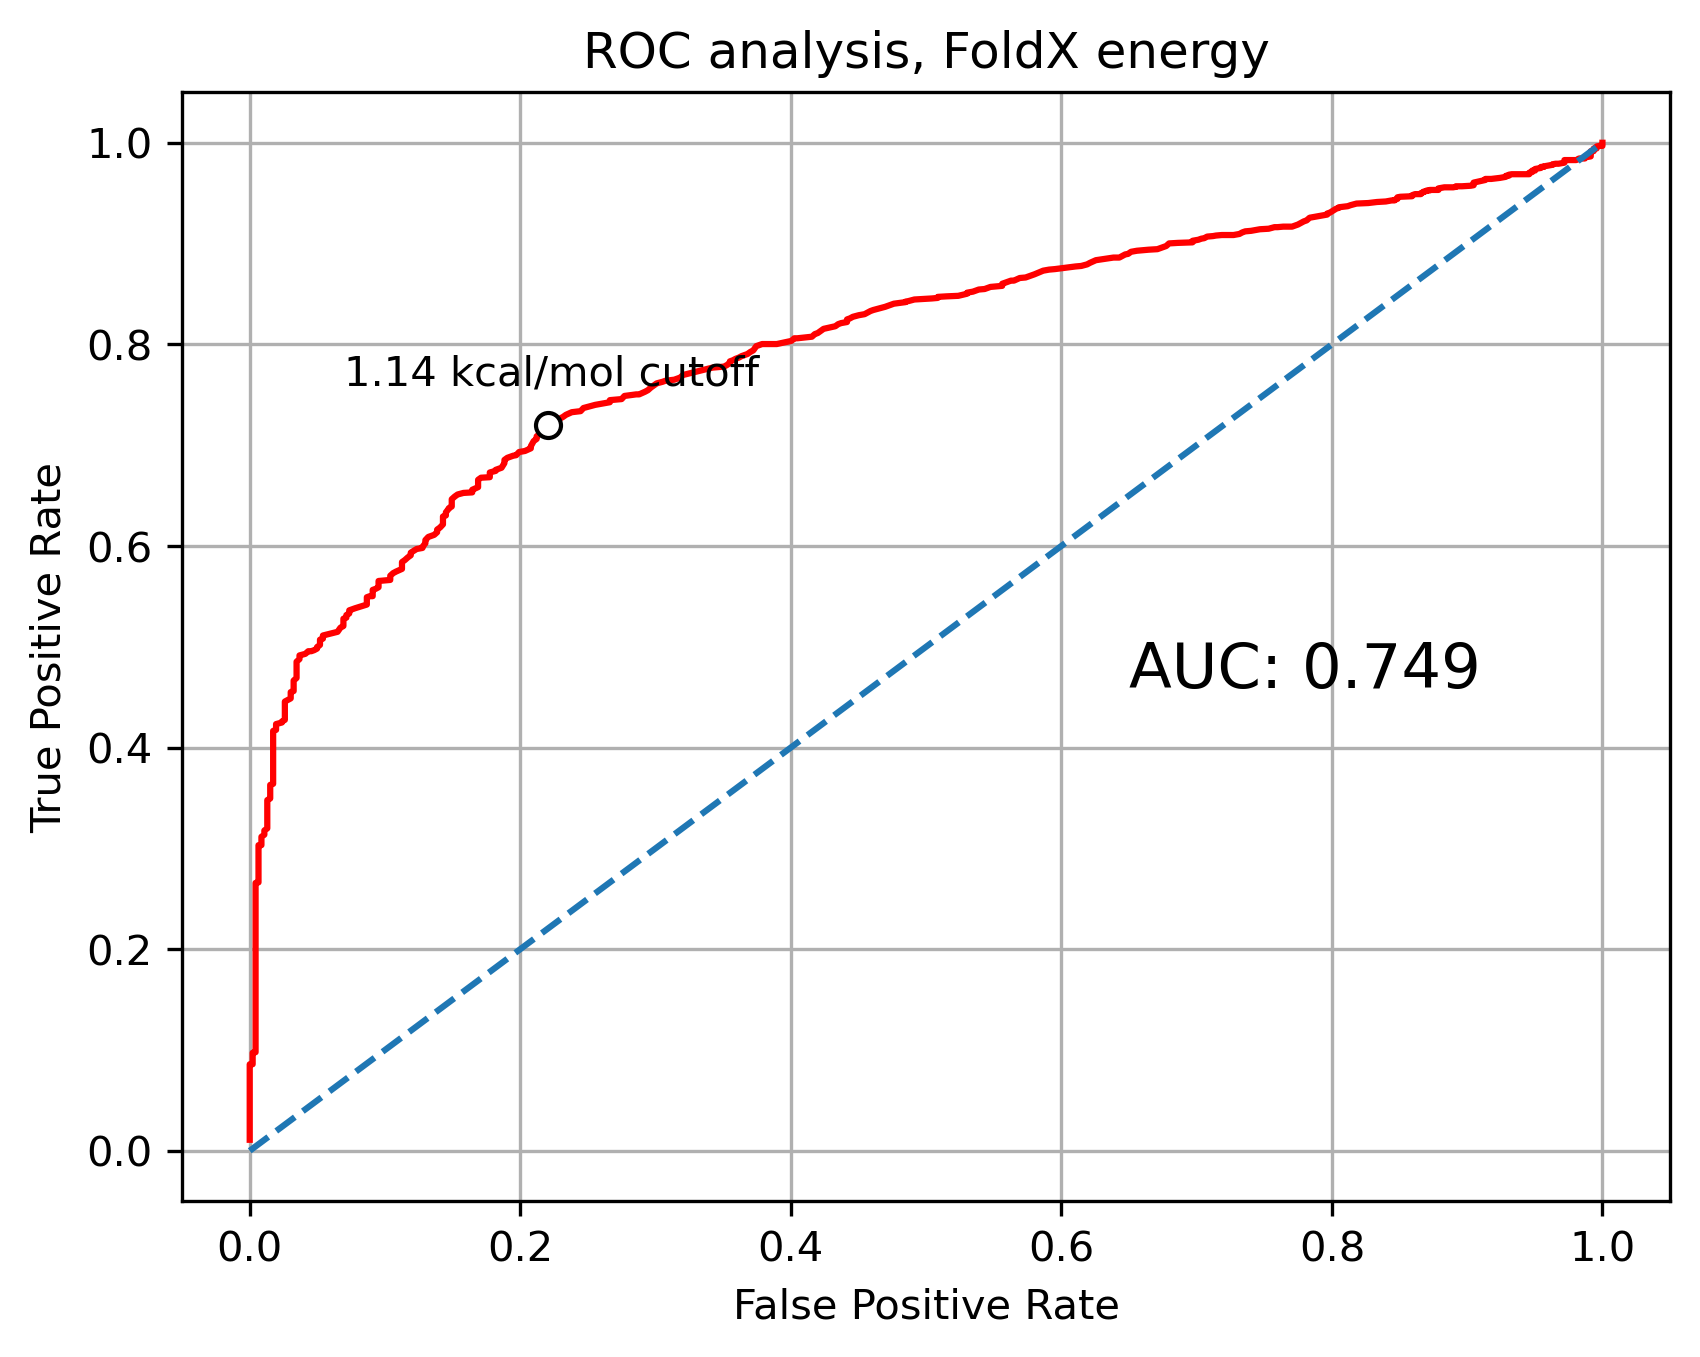

In [19]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(-5,20, 0.01):
    pred = []
    for item in plotting_frame["Foldx_energy"]:
        predvalue = 1 if item >= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

g3 = sns.scatterplot(x = [0.220779], y= [0.719709], zorder = 3, color = "white", edgecolor = "k", linewidth = 1)
plt.annotate("1.14 kcal/mol cutoff", (0.07,0.76))
plt.annotate("AUC: 0.749", (0.65,0.46),fontsize=15)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, FoldX energy")
plt.grid()
plt.show()

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
614,1.14,0.220779,0.719709,0.749465
612,1.12,0.225108,0.723869,0.749380
615,1.15,0.218615,0.716589,0.748987


## ROC Curve: Minimum distance to binding site A

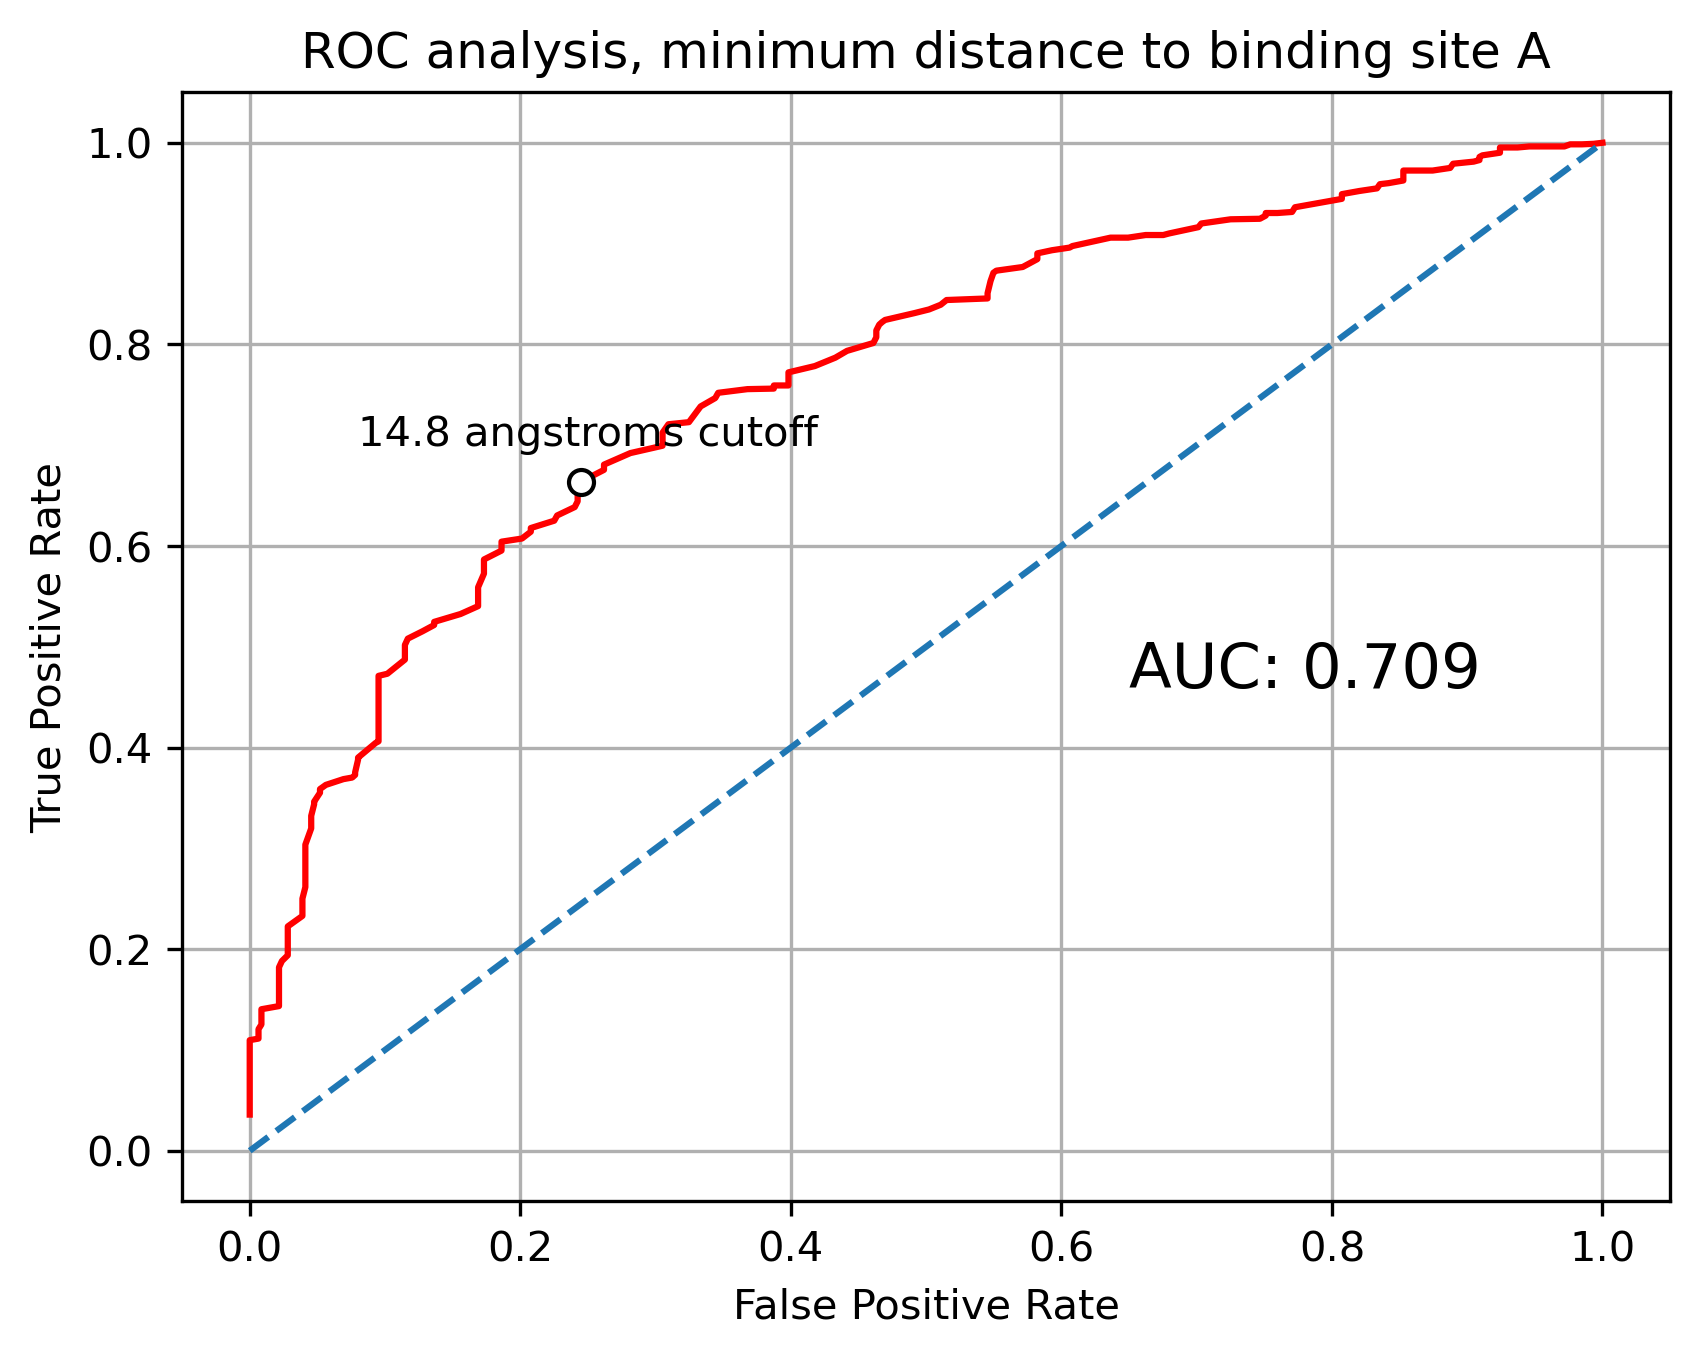

In [21]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,100, 0.1):
    pred = []
    for item in plotting_frame["Mindist_bindingsiteA"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

g3 = sns.scatterplot(x = [0.244589], y= [0.663547], zorder = 3, color = "white", edgecolor = "k", linewidth = 1)
plt.annotate("14.8 angstroms cutoff", (0.08,0.7))
plt.annotate("AUC: 0.709", (0.65,0.46),fontsize=15)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, minimum distance to binding site A")

plt.grid()
plt.show()

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
148,14.8,0.244589,0.663547,0.709479
150,15.0,0.261905,0.680707,0.709401
136,13.6,0.186147,0.604264,0.709058


So whilst not entirely accurate, the minimum distances to the binding site are still predicting the pathogenicity better than a random guessing model.

## ROC Curve: Minimum distance to hinge site

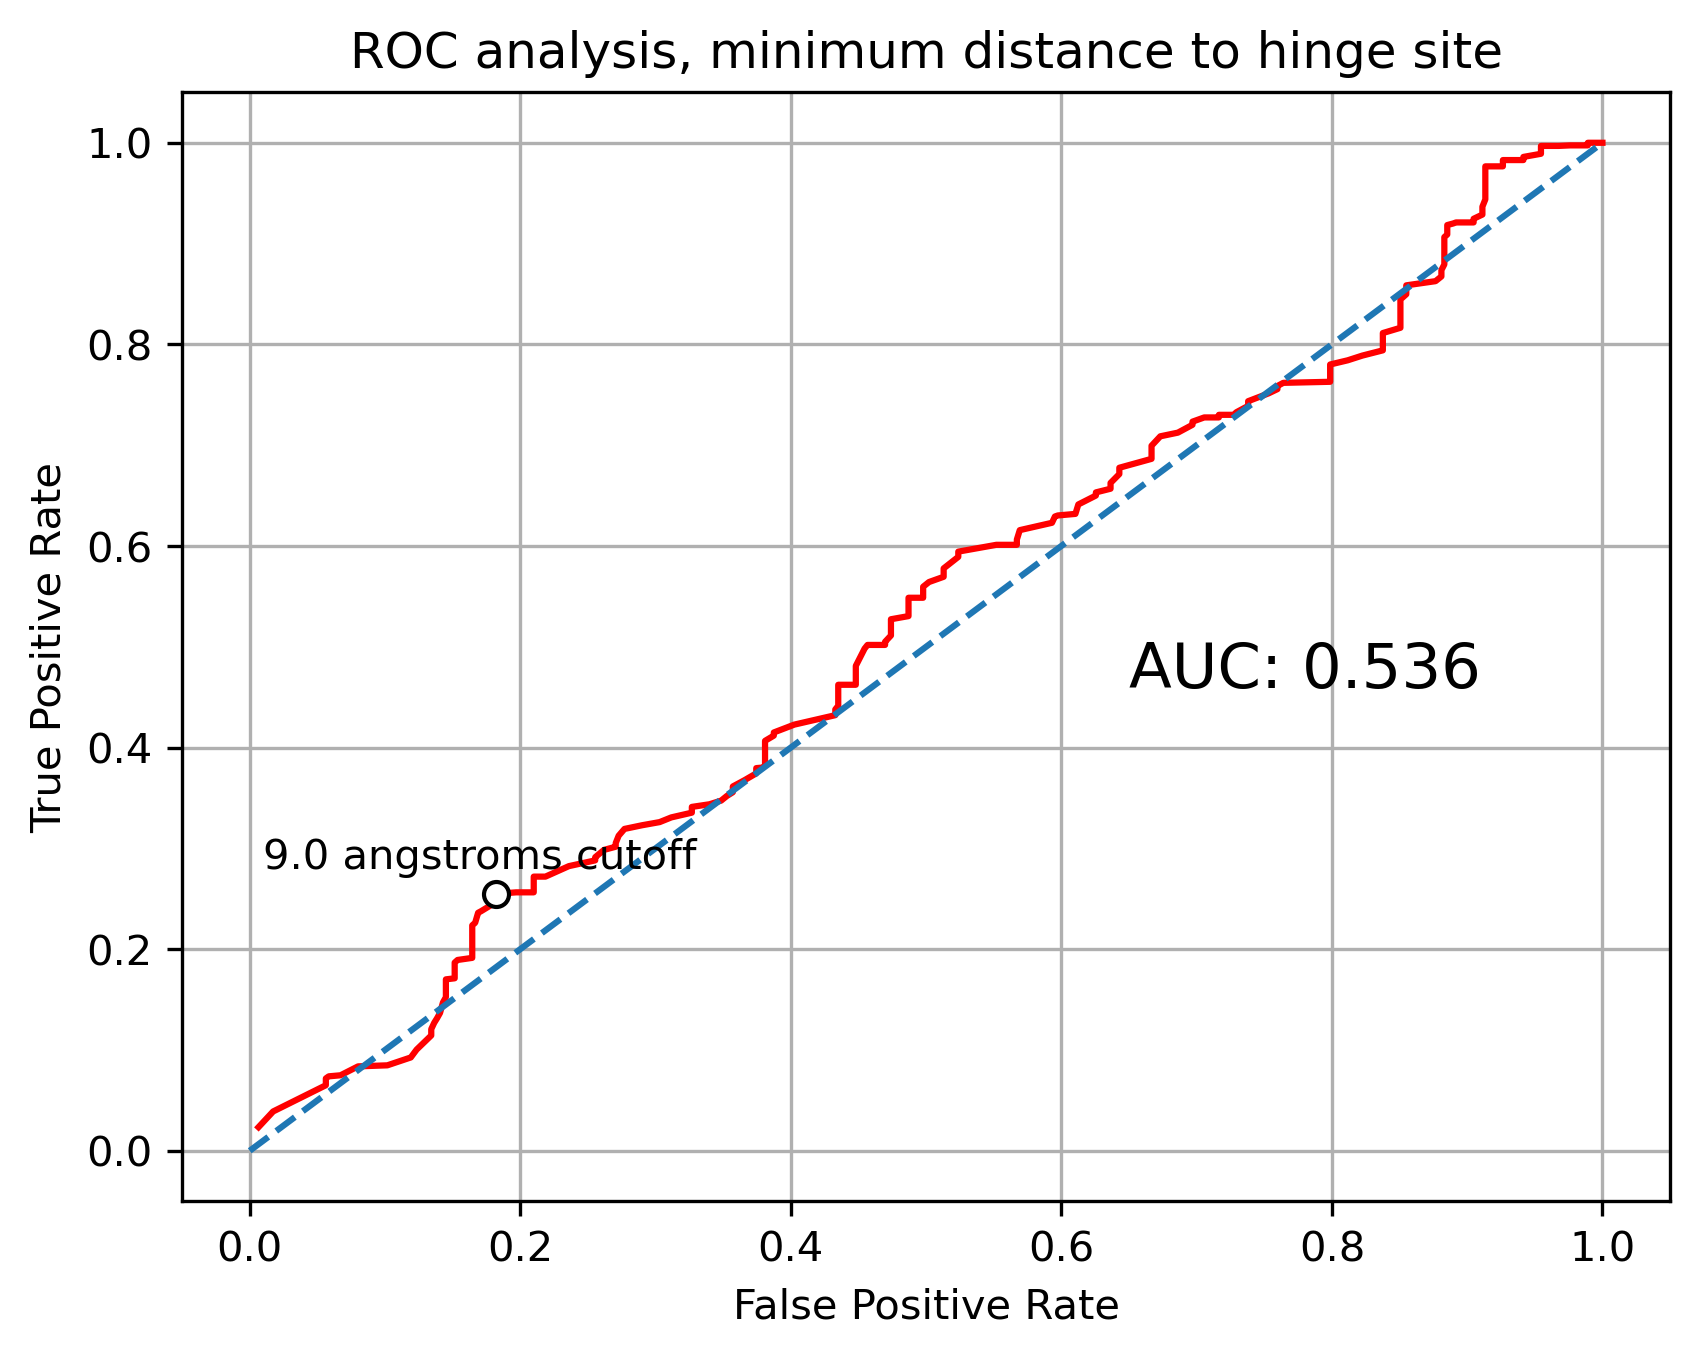

In [23]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,100, 0.1):
    pred = []
    for item in plotting_frame["Mindist_hinge"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

g3 = sns.scatterplot(x = [0.181818], y= [0.254810], zorder = 3, color = "white", edgecolor = "k", linewidth = 1)
plt.annotate("9.0 angstroms cutoff", (0.01,0.28))
plt.annotate("AUC: 0.536", (0.65,0.46),fontsize=15)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, minimum distance to hinge site")

plt.grid()
plt.show()

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
90,9.0,0.181818,0.254810,0.536496
162,16.2,0.523810,0.594384,0.535287
163,16.3,0.523810,0.594384,0.535287


This one is really odd. The closer we are to a hinge site, surely the more likely it is that our mutation is deleterious? Despite this, the classification is only doing about as good as a random guesser. That's really against intuition, at least with my limited knowledge.

An idea I have is to multiply these two metrics together. Maybe the two combined will do a better job at predicting the pathogenicity of mutations.

## ROC Curve: RSA

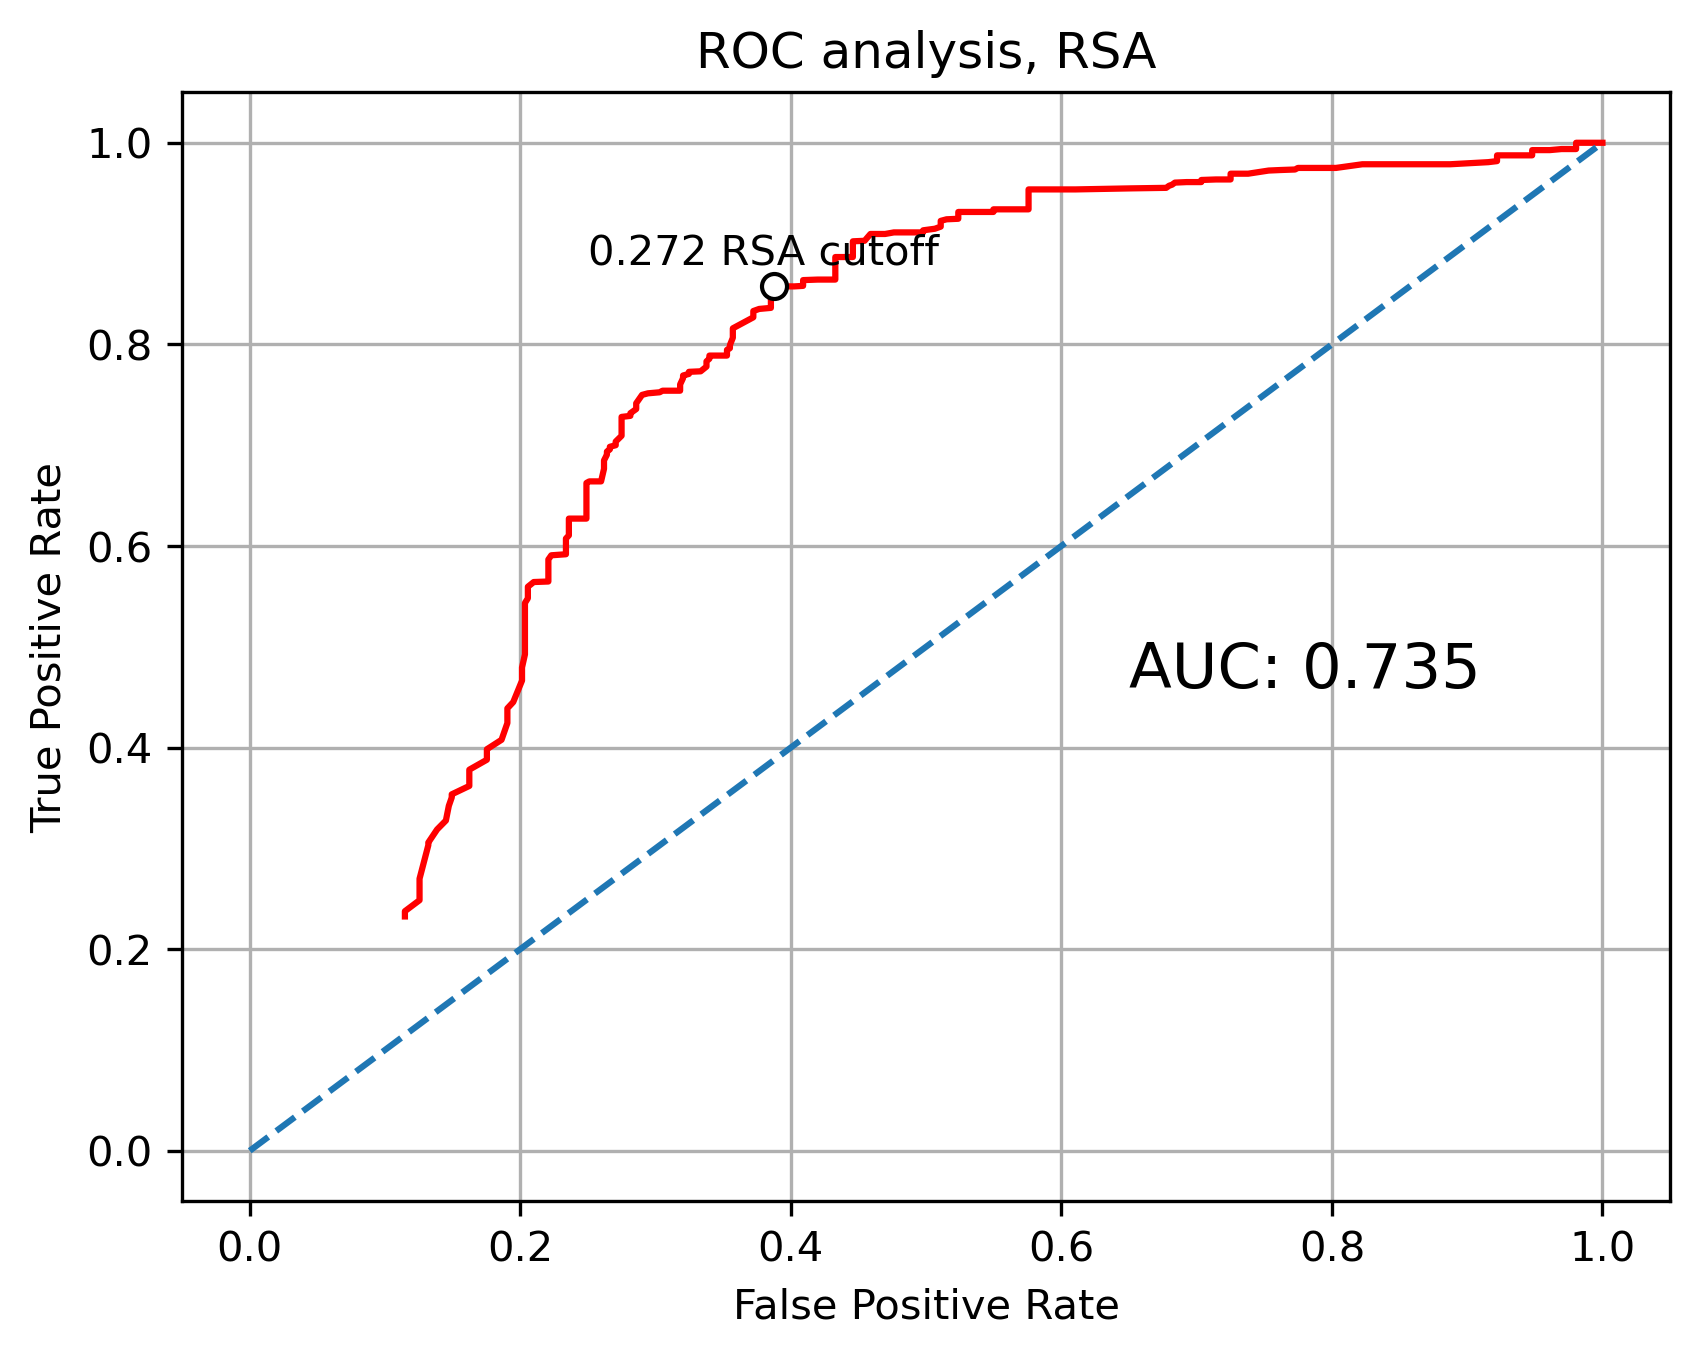

In [25]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,1, 0.001):
    pred = []
    for item in plotting_frame["RSA"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

g3 = sns.scatterplot(x = [0.387446], y= [0.857514], zorder = 3, color = "white", edgecolor = "k", linewidth = 1)
plt.annotate("0.272 RSA cutoff", (0.25,0.88))
plt.annotate("AUC: 0.735", (0.65,0.46),fontsize=15)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, RSA")

plt.grid()
plt.show()

In [26]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
272,0.272,0.387446,0.857514,0.735034
271,0.271,0.387446,0.857514,0.735034
273,0.273,0.387446,0.857514,0.735034


I'm assuming this has something to do with hydrophobicity... but someone needs to help me with this one.